<a href="https://colab.research.google.com/github/ask-cmder/Fine_Tuning_Llama/blob/main/Fine_Tuning_Llama_3_2_1B%2B3B_.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [85]:
pip install rouge-score

  Preparing metadata (setup.py) ... done
  Created wheel for rouge-score: filename=rouge_score-0.1.2-py3-none-any.whl size=24935 sha256=5703889f8b9d22f103ad3f8457b5b794e28bf13aa3a3d37ddad22742869a041d
  Stored in directory: /root/.cache/pip/wheels/5f/dd/89/461065a73be61a532ff8599a28e9beef17985c9e9c31e541b4
Successfully built rouge-score


In [2]:
from unsloth import FastLanguageModel
import torch
max_seq_length = 2048 # Choose any! We auto support RoPE Scaling internally!
dtype = None # None for auto detection. Float16 for Tesla T4, V100, Bfloat16 for Ampere+
load_in_4bit = True # Use 4bit quantization to reduce memory usage. Can be False.

# 4bit pre quantized models we support for 4x faster downloading + no OOMs.
fourbit_models = [
    "unsloth/Meta-Llama-3.1-8B-bnb-4bit",      # Llama-3.1 2x faster
    "unsloth/Meta-Llama-3.1-8B-Instruct-bnb-4bit",
    "unsloth/Meta-Llama-3.1-70B-bnb-4bit",
    "unsloth/Meta-Llama-3.1-405B-bnb-4bit",    # 4bit for 405b!
    "unsloth/Mistral-Small-Instruct-2409",     # Mistral 22b 2x faster!
    "unsloth/mistral-7b-instruct-v0.3-bnb-4bit",
    "unsloth/Phi-3.5-mini-instruct",           # Phi-3.5 2x faster!
    "unsloth/Phi-3-medium-4k-instruct",
    "unsloth/gemma-2-9b-bnb-4bit",
    "unsloth/gemma-2-27b-bnb-4bit",            # Gemma 2x faster!

    "unsloth/Llama-3.2-1B-bnb-4bit",           # NEW! Llama 3.2 models
    "unsloth/Llama-3.2-1B-Instruct-bnb-4bit",
    "unsloth/Llama-3.2-3B-bnb-4bit",
    "unsloth/Llama-3.2-3B-Instruct-bnb-4bit",

    "unsloth/Llama-3.3-70B-Instruct-bnb-4bit" # NEW! Llama 3.3 70B!
] # More models at https://huggingface.co/unsloth

model, tokenizer = FastLanguageModel.from_pretrained(
    model_name = "unsloth/Llama-3.2-3B-Instruct", # or choose "unsloth/Llama-3.2-1B-Instruct"
    max_seq_length = max_seq_length,
    dtype = dtype,
    load_in_4bit = load_in_4bit,
    token = "hf_"#, # use one if using gated models like meta-llama/Llama-2-7b-hf
)

🦥 Unsloth: Will patch your computer to enable 2x faster free finetuning.
🦥 Unsloth Zoo will now patch everything to make training faster!
==((====))==  Unsloth 2024.12.4: Fast Llama patching. Transformers:4.46.3.
   \\   /|    GPU: Tesla T4. Max memory: 14.748 GB. Platform: Linux.
O^O/ \_/ \    Torch: 2.5.1+cu121. CUDA: 7.5. CUDA Toolkit: 12.1. Triton: 3.1.0
\        /    Bfloat16 = FALSE. FA [Xformers = 0.0.28.post3. FA2 = False]
 "-____-"     Free Apache license: http://github.com/unslothai/unsloth
Unsloth: Fast downloading is enabled - ignore downloading bars which are red colored!


model.safetensors:   0%|          | 0.00/2.24G [00:00<?, ?B/s]

generation_config.json:   0%|          | 0.00/184 [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/54.6k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/9.09M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/454 [00:00<?, ?B/s]

We now add LoRA adapters so we only need to update 1 to 10% of all parameters!

In [3]:
model = FastLanguageModel.get_peft_model(
    model,
    r = 16, # Choose any number > 0 ! Suggested 8, 16, 32, 64, 128
    target_modules = ["q_proj", "k_proj", "v_proj", "o_proj",
                      "gate_proj", "up_proj", "down_proj",],
    lora_alpha = 16,
    lora_dropout = 0, # Supports any, but = 0 is optimized
    bias = "none",    # Supports any, but = "none" is optimized
    # [NEW] "unsloth" uses 30% less VRAM, fits 2x larger batch sizes!
    use_gradient_checkpointing = "unsloth", # True or "unsloth" for very long context
    random_state = 3407,
    use_rslora = False,  # We support rank stabilized LoRA
    loftq_config = None, # And LoftQ
)

Unsloth 2024.12.4 patched 28 layers with 28 QKV layers, 28 O layers and 28 MLP layers.


In [4]:
from unsloth.chat_templates import get_chat_template

tokenizer = get_chat_template(
    tokenizer,
    chat_template = "llama-3.1",
)

def formatting_prompts_func(examples):
    convos = examples["conversations"]
    texts = [tokenizer.apply_chat_template(convo, tokenize = False, add_generation_prompt = False) for convo in convos]
    return { "text" : texts, }
pass

from datasets import load_dataset
dataset = load_dataset("belgiumhorse/share_gpt_style_patient_radiologist_data", split = "train")

(…)_gpt_style_patient_radiologist_data.json:   0%|          | 0.00/108k [00:00<?, ?B/s]

Generating train split:   0%|          | 0/28 [00:00<?, ? examples/s]

In [5]:
from unsloth.chat_templates import standardize_sharegpt
dataset = standardize_sharegpt(dataset)
dataset = dataset.map(formatting_prompts_func, batched = True,)

Standardizing format:   0%|          | 0/28 [00:00<?, ? examples/s]

Map:   0%|          | 0/28 [00:00<?, ? examples/s]

In [6]:
dataset[5]["conversations"]

[{'content': "Doctor, I've been experiencing some unusual symptoms lately and I'm hoping you can help me figure out what's going on. Here's what I've noticed:\n\n* I wake up every morning with a tight, constricted feeling in my chest that lasts for hours. It's hard to explain, but it feels like there's a vice wrapped around my heart.\n* My breathing gets labored when I exert myself, even simple tasks like taking the stairs or carrying groceries. I feel like I'm getting winded way too easily.\n* My lungs seem to be producing more mucus than usual, and I've had several coughing fits that leave me gasping for air. Sometimes, it's so bad that I have to use a tissue to catch my breath.\n* When I lay down to sleep, I feel like my chest is going to cave in on itself. It's really uncomfortable and keeps me awake at night.\n* I've noticed that I get short of breath even when I'm just sitting still, watching TV or reading a book. My heart rate increases, and I feel like I need to catch my breath

In [7]:
dataset[5]["text"]

"<|begin_of_text|><|start_header_id|>system<|end_header_id|>\n\nCutting Knowledge Date: December 2023\nToday Date: 26 July 2024\n\n<|eot_id|><|start_header_id|>user<|end_header_id|>\n\nDoctor, I've been experiencing some unusual symptoms lately and I'm hoping you can help me figure out what's going on. Here's what I've noticed:\n\n* I wake up every morning with a tight, constricted feeling in my chest that lasts for hours. It's hard to explain, but it feels like there's a vice wrapped around my heart.\n* My breathing gets labored when I exert myself, even simple tasks like taking the stairs or carrying groceries. I feel like I'm getting winded way too easily.\n* My lungs seem to be producing more mucus than usual, and I've had several coughing fits that leave me gasping for air. Sometimes, it's so bad that I have to use a tissue to catch my breath.\n* When I lay down to sleep, I feel like my chest is going to cave in on itself. It's really uncomfortable and keeps me awake at night.\n* 

In [8]:
from trl import SFTTrainer
from transformers import TrainingArguments, DataCollatorForSeq2Seq
from unsloth import is_bfloat16_supported

trainer = SFTTrainer(
    model = model,
    tokenizer = tokenizer,
    train_dataset = dataset,
    dataset_text_field = "text",
    max_seq_length = max_seq_length,
    data_collator = DataCollatorForSeq2Seq(tokenizer = tokenizer),
    dataset_num_proc = 2,
    packing = False, # Can make training 5x faster for short sequences.
    args = TrainingArguments(
        per_device_train_batch_size = 2,
        gradient_accumulation_steps = 4,
        warmup_steps = 5,
        # num_train_epochs = 1, # Set this for 1 full training run.
        max_steps = 60,
        learning_rate = 2e-4,
        fp16 = not is_bfloat16_supported(),
        bf16 = is_bfloat16_supported(),
        logging_steps = 1,
        optim = "adamw_8bit",
        weight_decay = 0.01,
        lr_scheduler_type = "linear",
        seed = 3407,
        output_dir = "outputs",
        report_to = "none", # Use this for WandB etc
    ),
)

Map (num_proc=2):   0%|          | 0/28 [00:00<?, ? examples/s]

max_steps is given, it will override any value given in num_train_epochs


In [9]:
from unsloth.chat_templates import train_on_responses_only
trainer = train_on_responses_only(
    trainer,
    instruction_part = "<|start_header_id|>user<|end_header_id|>\n\n",
    response_part = "<|start_header_id|>assistant<|end_header_id|>\n\n",
)

Map:   0%|          | 0/28 [00:00<?, ? examples/s]

In [10]:
tokenizer.decode(trainer.train_dataset[5]["input_ids"])

"<|begin_of_text|><|start_header_id|>system<|end_header_id|>\n\nCutting Knowledge Date: December 2023\nToday Date: 26 July 2024\n\n<|eot_id|><|start_header_id|>user<|end_header_id|>\n\nDoctor, I've been experiencing some unusual symptoms lately and I'm hoping you can help me figure out what's going on. Here's what I've noticed:\n\n* I wake up every morning with a tight, constricted feeling in my chest that lasts for hours. It's hard to explain, but it feels like there's a vice wrapped around my heart.\n* My breathing gets labored when I exert myself, even simple tasks like taking the stairs or carrying groceries. I feel like I'm getting winded way too easily.\n* My lungs seem to be producing more mucus than usual, and I've had several coughing fits that leave me gasping for air. Sometimes, it's so bad that I have to use a tissue to catch my breath.\n* When I lay down to sleep, I feel like my chest is going to cave in on itself. It's really uncomfortable and keeps me awake at night.\n* 

In [11]:
space = tokenizer(" ", add_special_tokens = False).input_ids[0]
tokenizer.decode([space if x == -100 else x for x in trainer.train_dataset[5]["labels"]])

"                                                                                                                                                                                                                                                                                                                                                               \n\nBased on your symptoms and the X-ray image provided, the diagnosis appears to be Respiratory Distress Syndrome (RDS) due to a severe infection affecting both lungs.\n\nThe presence of lung consolidation and pleural effusion in the X-ray findings suggests that the underlying disease process could be quite severe or complicated. Possible complications may include:\n\n1. Acute Respiratory Distress Syndrome (ARDS): A potentially life-threatening complication characterized by widespread inflammation in the lungs and fluid buildup within the alveoli, making it difficult for the patient to breathe.\n2. Sepsis: A systemic inflammatory response 

In [12]:
#@title Show current memory stats
gpu_stats = torch.cuda.get_device_properties(0)
start_gpu_memory = round(torch.cuda.max_memory_reserved() / 1024 / 1024 / 1024, 3)
max_memory = round(gpu_stats.total_memory / 1024 / 1024 / 1024, 3)
print(f"GPU = {gpu_stats.name}. Max memory = {max_memory} GB.")
print(f"{start_gpu_memory} GB of memory reserved.")

GPU = Tesla T4. Max memory = 14.748 GB.
2.635 GB of memory reserved.


In [13]:
trainer_stats = trainer.train()

==((====))==  Unsloth - 2x faster free finetuning | Num GPUs = 1
   \\   /|    Num examples = 28 | Num Epochs = 20
O^O/ \_/ \    Batch size per device = 2 | Gradient Accumulation steps = 4
\        /    Total batch size = 8 | Total steps = 60
 "-____-"     Number of trainable parameters = 24,313,856


Step,Training Loss
1,1.107700
2,1.160900
3,1.075900
4,1.601800
5,1.129000
6,0.963100
7,1.452100
8,1.006700
9,0.781700
10,0.845100


In [14]:
#@title Show final memory and time stats
used_memory = round(torch.cuda.max_memory_reserved() / 1024 / 1024 / 1024, 3)
used_memory_for_lora = round(used_memory - start_gpu_memory, 3)
used_percentage = round(used_memory         /max_memory*100, 3)
lora_percentage = round(used_memory_for_lora/max_memory*100, 3)
print(f"{trainer_stats.metrics['train_runtime']} seconds used for training.")
print(f"{round(trainer_stats.metrics['train_runtime']/60, 2)} minutes used for training.")
print(f"Peak reserved memory = {used_memory} GB.")
print(f"Peak reserved memory for training = {used_memory_for_lora} GB.")
print(f"Peak reserved memory % of max memory = {used_percentage} %.")
print(f"Peak reserved memory for training % of max memory = {lora_percentage} %.")

524.8198 seconds used for training.
8.75 minutes used for training.
Peak reserved memory = 4.324 GB.
Peak reserved memory for training = 1.689 GB.
Peak reserved memory % of max memory = 29.319 %.
Peak reserved memory for training % of max memory = 11.452 %.


In [15]:
from unsloth.chat_templates import get_chat_template

tokenizer = get_chat_template(
    tokenizer,
    chat_template = "llama-3.1",
)
FastLanguageModel.for_inference(model) # Enable native 2x faster inference

messages = [
    {"role": "user", "content": "Doctor, I've been experiencing some really frustrating symptoms lately. I feel like I'm having trouble breathing, especially at night"},
]
inputs = tokenizer.apply_chat_template(
    messages,
    tokenize = True,
    add_generation_prompt = True, # Must add for generation
    return_tensors = "pt",
).to("cuda")

outputs = model.generate(input_ids = inputs, max_new_tokens = 64, use_cache = True,
                         temperature = 1.5, min_p = 0.1)
tokenizer.batch_decode(outputs)

The attention mask is not set and cannot be inferred from input because pad token is same as eos token. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.


["<|begin_of_text|><|start_header_id|>system<|end_header_id|>\n\nCutting Knowledge Date: December 2023\nToday Date: 26 July 2024\n\n<|eot_id|><|start_header_id|>user<|end_header_id|>\n\nDoctor, I've been experiencing some really frustrating symptoms lately. I feel like I'm having trouble breathing, especially at night<|eot_id|><|start_header_id|>assistant<|end_header_id|>\n\nAs an expert radiologist, I'd like to discuss the potential causes of your symptoms in more detail. Based on the X-ray image, it appears that there may be some bronchial wall thickening or inflammation in the lower lung fields, which could be consistent with bronchitis or other respiratory conditions.\n\nThe presence"]

In [16]:
FastLanguageModel.for_inference(model) # Enable native 2x faster inference

messages = [
    {"role": "user", "content": "Doctor, I've been experiencing some really frustrating symptoms lately. I feel like I'm having trouble breathing, especially at night"},
]
inputs = tokenizer.apply_chat_template(
    messages,
    tokenize = True,
    add_generation_prompt = True, # Must add for generation
    return_tensors = "pt",
).to("cuda")

from transformers import TextStreamer
text_streamer = TextStreamer(tokenizer, skip_prompt = True)
_ = model.generate(input_ids = inputs, streamer = text_streamer, max_new_tokens = 128,
                   use_cache = True, temperature = 1.5, min_p = 0.1)

Based on the X-ray image and considering disease contexts such as COPD, the initial impression is that there may be signs indicative of airways obstruction or inflammation within the lower chest region.

The presence of cloudiness in the lower chest area could represent fluid buildup or inflammation, which could be associated with COPD or another underlying condition. The diaphragm appears normal in position, suggesting that it is functioning properly.

Given the symptoms you've described, including difficulty breathing and shortness of breath, particularly at night, these findings are concerning for a possible diagnosis of COPD or another respiratory condition.<|eot_id|>


In [17]:
model.save_pretrained("patient_radiologist_lora_model") # Local saving
tokenizer.save_pretrained("patient_radiologist_lora_model")

('patient_radiologist_lora_model/tokenizer_config.json',
 'patient_radiologist_lora_model/special_tokens_map.json',
 'patient_radiologist_lora_model/tokenizer.json')

In [18]:
model.save_pretrained_gguf("patient_radiologist_lora_model", tokenizer, quantization_method = "f16")

Unsloth: You have 1 CPUs. Using `safe_serialization` is 10x slower.
We shall switch to Pytorch saving, which might take 3 minutes and not 30 minutes.
To force `safe_serialization`, set it to `None` instead.
Unsloth: Kaggle/Colab has limited disk space. We need to delete the downloaded
model which will save 4-16GB of disk space, allowing you to save on Kaggle/Colab.
Unsloth: Will remove a cached repo with size 2.2G


Unsloth: Merging 4bit and LoRA weights to 16bit...
Unsloth: Will use up to 5.53 out of 12.67 RAM for saving.
Unsloth: Saving model... This might take 5 minutes ...


100%|██████████| 28/28 [00:01<00:00, 18.01it/s]


Unsloth: Saving tokenizer... Done.
Unsloth: Saving patient_radiologist_lora_model/pytorch_model-00001-of-00002.bin...
Unsloth: Saving patient_radiologist_lora_model/pytorch_model-00002-of-00002.bin...
Done.


Unsloth: Converting llama model. Can use fast conversion = False.


==((====))==  Unsloth: Conversion from QLoRA to GGUF information
   \\   /|    [0] Installing llama.cpp might take 3 minutes.
O^O/ \_/ \    [1] Converting HF to GGUF 16bits might take 3 minutes.
\        /    [2] Converting GGUF 16bits to ['f16'] might take 10 minutes each.
 "-____-"     In total, you will have to wait at least 16 minutes.

Unsloth: Installing llama.cpp. This might take 3 minutes...
Unsloth: CMAKE detected. Finalizing some steps for installation.
Unsloth: [1] Converting model at patient_radiologist_lora_model into f16 GGUF format.
The output location will be /content/patient_radiologist_lora_model/unsloth.F16.gguf
This might take 3 minutes...
INFO:hf-to-gguf:Loading model: patient_radiologist_lora_model
INFO:gguf.gguf_writer:gguf: This GGUF file is for Little Endian only
INFO:hf-to-gguf:Exporting model...
INFO:hf-to-gguf:rope_freqs.weight,           torch.float32 --> F32, shape = {64}
INFO:hf-to-gguf:gguf: loading model weight map from 'pytorch_model.bin.index.json'
IN

In [19]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [20]:
import shutil

# Path to the source directory (on Colab)
source_dir = '/content/patient_radiologist_lora_model/'  # Replace with your source directory

# Path to the destination directory (on Google Drive)
destination_dir = '/content/drive/My Drive/file_tune_llama/patient_radiologist_lora_model/'  # Replace with your desired destination

# Copy the entire directory to Google Drive
shutil.copytree(source_dir, destination_dir)


'/content/drive/My Drive/file_tune_llama/patient_radiologist_lora_model/'

In [21]:
import nltk
import matplotlib.pyplot as plt
from nltk.translate.bleu_score import sentence_bleu
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.metrics import accuracy_score
from sentence_transformers import SentenceTransformer

In [22]:
nltk.download('punkt')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


True

In [23]:
test_dataset = load_dataset("belgiumhorse/gen_patient_radiologist_data", split = "train")

patient_radiologist_data.json:   0%|          | 0.00/103k [00:00<?, ?B/s]

Generating train split:   0%|          | 0/28 [00:00<?, ? examples/s]

In [25]:
test_dataset[0]['instruction']

"Doctor, I've been experiencing some really frustrating symptoms lately. I feel like I'm having trouble breathing, especially at night when I lie down. My chest feels tight and constricted, like someone is squeezing it from the inside out. Sometimes I can barely catch my breath after even minor physical exertion.\n\nI've also noticed that I get these awful coughing fits, where I'll be sitting or standing just fine, and then suddenly I'm gasping for air and wheezing like a dying animal. It's really scary, to be honest. And it's not just the coughing – my whole body feels weak and tired all the time.\n\nI've also been feeling pretty bloated and puffy, especially around my ankles and hands. I know it sounds weird, but it's like my skin is retaining water or something. And when I try to walk or even just stand up from a seated position, I feel like I'm going to pass out. It's really disorienting.\n\nSometimes I get these weird feelings of pressure in my chest that make me worry that I migh

In [26]:
test_dataset[0]['output']

"Based on the patient's symptoms and the X-ray image analysis, I would like to provide some additional observations and insights.\n\nFrom a radiological perspective, the lungs appear clear and well-expanded, which is consistent with normal function. However, it's essential to note that the X-ray image may not be able to detect all types of lung abnormalities, such as small nodules or infiltrates.\n\nGiven the patient's symptoms of difficulty breathing, coughing fits, and feeling weak and tired, it's possible that there might be an underlying condition affecting her respiratory system. Some potential diagnoses that come to mind based on the X-ray image include bronchitis, pneumonia, or chronic obstructive pulmonary disease (COPD). However, these are just possibilities and would require further diagnostic testing and evaluation.\n\nIt's also worth noting that the patient's symptoms of feeling bloated and puffy, as well as feeling like she might pass out when standing up, could be related

In [27]:
import pandas as pd
data = []
for example in test_dataset:
    instruction = example["instruction"]  # Access the 'instruction' column
    input_text = example["input"]         # Access the 'input' column
    output_text = example["output"]       # Access the 'output' column
    data.append({'input': instruction, 'output': output_text, 'model_output':" "})

df = pd.DataFrame(data)
df.head(1)

,input,output,model_output
0,"Doctor, I've been experiencing some really fru...",Based on the patient's symptoms and the X-ray ...,


In [62]:
df = df.dropna(subset=['model_output'])

In [63]:
df.head(2)

,input,output,model_output
0,"Doctor, I've been experiencing some really fru...",Based on the patient's symptoms and the X-ray ...,\nBased on the symptoms reported by the patien...
1,"Doctor, I've been feeling really unwell lately...",Based on the X-ray image and considering the d...,\n**Initial Impression:**\nBased on the sympto...


In [107]:
# Convert the DataFrame into the specified conversation_data format
conversation_data = []

# Iterate over each row in the DataFrame
for _, row in df.iterrows():
    # Create a dictionary for each conversation
    conversation = {
        "input": row['input'],
        "output": row['output'],
        "predicted_output": row['model_output']
    }

    # Append the dictionary to the conversation_data list
    conversation_data.append(conversation)


In [65]:
def exact_match_accuracy(df):
    correct = 0
    total = len(conversation_data)

    for conversation in conversation_data:
        if conversation['output'] == conversation['predicted_output']:
            correct += 1

    em_accuracy = correct / total
    return em_accuracy

In [66]:
def bleu_score(conversation_data):
    bleu_scores = []
    for conversation in conversation_data:
        reference = nltk.word_tokenize(conversation['output'])
        candidate = nltk.word_tokenize(conversation['predicted_output'])
        bleu_score = sentence_bleu([reference], candidate)
        bleu_scores.append(bleu_score)

    avg_bleu_score = sum(bleu_scores) / len(bleu_scores)
    return avg_bleu_score

In [67]:
def cosine_similarity_score(conversation_data):
    cosine_similarities = []

    for conversation in conversation_data:
        # Encode the sentences into embeddings
        output_embedding = model.encode(conversation['output'])
        predicted_output_embedding = model.encode(conversation['predicted_output'])

        # Compute cosine similarity between predicted output and the reference
        similarity = cosine_similarity([output_embedding], [predicted_output_embedding])
        cosine_similarities.append(similarity[0][0])

    avg_cosine_similarity = sum(cosine_similarities) / len(cosine_similarities)
    return avg_cosine_similarity

In [70]:
nltk.download('punkt_tab')
exact_match_list = []
bleu_score_list = []

# Iterate over each conversation and calculate metrics
for conversation in conversation_data:
    # Calculate Exact Match accuracy
    em_accuracy = exact_match_accuracy([conversation])
    exact_match_list.append(em_accuracy * 100)  # Convert to percentage

    # Calculate BLEU score
    bleu_score_value = bleu_score([conversation])
    bleu_score_list.append(bleu_score_value)


[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!
/usr/local/lib/python3.10/dist-packages/nltk/translate/bleu_score.py:577: UserWarning: 
The hypothesis contains 0 counts of 4-gram overlaps.
Therefore the BLEU score evaluates to 0, independently of
how many N-gram overlaps of lower order it contains.
Consider using lower n-gram order or use SmoothingFunction()
  warnings.warn(_msg)


In [76]:
# Print overall metrics
print(f"Exact Match Accuracy: {sum(exact_match_list) / len(exact_match_list):.2f}%")
print(f"Average BLEU Score: {sum(bleu_score_list) / len(bleu_score_list):.4f}")


Exact Match Accuracy: 0.00%
Average BLEU Score: 0.0102


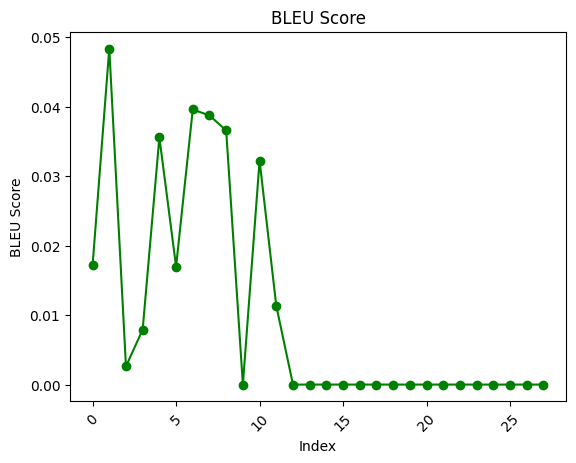

In [81]:
plt.plot([idx for idx, conversation in enumerate(conversation_data)], bleu_score_list, marker='o', linestyle='-', color='g')
plt.xlabel('Index')  # Label for the x-axis as index
plt.title('BLEU Score')
plt.ylabel('BLEU Score')
plt.tick_params(axis='x', rotation=45)

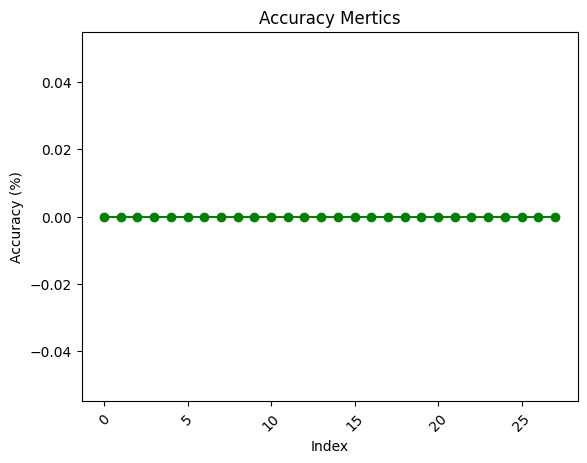

In [83]:
plt.plot([idx for idx, conversation in enumerate(conversation_data)], exact_match_list, marker='o', linestyle='-', color='g')
plt.xlabel('Index')  # Label for the x-axis as index
plt.title('Accuracy Mertics')
plt.ylabel('Accuracy (%)')
plt.tick_params(axis='x', rotation=45)

In [92]:
import nltk
from sklearn.metrics import accuracy_score, precision_recall_fscore_support
from nltk.translate.bleu_score import corpus_bleu
from rouge_score import rouge_scorer
import numpy as np

In [103]:
import nltk
from sklearn.metrics import accuracy_score, precision_recall_fscore_support
from nltk.translate.bleu_score import corpus_bleu
from rouge_score import rouge_scorer
import numpy as np

# Function to calculate evaluation metrics
def evaluate_metrics(expected_outputs, model_outputs):
    accuracy = accuracy_score(expected_outputs, model_outputs)

    precision, recall, f1, _ = precision_recall_fscore_support(expected_outputs, model_outputs, average='macro')

    bleu_score = corpus_bleu([[output.split()] for output in expected_outputs],
                              [output.split() for output in model_outputs])


    def levenshtein_distance(str1, str2):
        m, n = len(str1), len(str2)
        dp = np.zeros((m + 1, n + 1))
        for i in range(m + 1):
            for j in range(n + 1):
                if i == 0:
                    dp[i][j] = j
                elif j == 0:
                    dp[i][j] = i
                else:
                    dp[i][j] = min(dp[i-1][j] + 1, dp[i][j-1] + 1, dp[i-1][j-1] + (str1[i-1] != str2[j-1]))
        return dp[m][n]

    edit_distances = [levenshtein_distance(expected, model) for expected, model in zip(expected_outputs, model_outputs)]
    avg_edit_distance = np.mean(edit_distances)

    return {
        'accuracy': accuracy,
        'precision': precision,
        'recall': recall,
        'f1_score': f1,
        'bleu_score': bleu_score,
        'avg_edit_distance': avg_edit_distance
    }

In [106]:
expected_outputs = [conversation['output'] for conversation in conversation_data]
model_outputs = [conversation['predicted_output'] for conversation in conversation_data]
metrics = evaluate_metrics(expected_outputs, model_outputs)

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


In [104]:
print(metrics)

{'accuracy': 0.0, 'precision': 0.0, 'recall': 0.0, 'f1_score': 0.0, 'bleu_score': 0.00026991950456167497, 'avg_edit_distance': 1836.892857142857}
